<h3>CMM Sample Data Crustal Thickness Analysis - Method, Results, and Interpretation</h3>

__Notebook Initial Creation:__ 1/20/2017 <br>
__Author:__ pjparis

<h4>Initial Data Load:</h4>

In [35]:
fpath='/Users/paulp/GoogleDrive/projects/ContinentalMarginMapping/data/GCS_EDA_sampling/'
file='CMM_20krandompnts.csv'

df = pd.read_csv(fpath+file, names=['ID','CrustThk','Elevation','Magnetic','Gravity','gForms','Lon','Lat'], skiprows=1).dropna()

<h4>Data Preprocessing:</h4>

In [36]:
# import the Matplotlib plotting handlers:
from matplotlib import pyplot as plt

%matplotlib inline

# Render crustal thickness as positive values. Prior were all measured as
# distances from the sea bed to base of crust (Moho) so < 0:
df.CrustThk = df.CrustThk* -1

# build the arrays needed for the Natural Breaks from the df:
X = df.ix[:,1:5]                # extract the continuous numeric fields in df
y = np.array(df.ix[:,5] )       # extract the geomorphon type classifier field only


<h4>The Fisher-Jenks Natural Breaks Optimization Routine - Part A: the Callable Functions</h4>

In [28]:
import random
from pysal.esda.mapclassify import Natural_Breaks as nb
import time

def ComputeNaturalBreaks(pc_array, klasses):
    '''
    partitions data into classes using PySAL pysal.esda.mapclassify, Natural_Breaks algorithm. 
    input: array of values to classify
    returns: upper bounds for classes
    '''
    breaks=nb(pc_array, k=klasses, initial=20)
    return(breaks)


def goodness_of_variance_fit(array, classes):
    # get the break points
    #classes = jenks(array, classes)

    # do the actual classification - assign values based on class breaks
    classified = np.array([classify(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf


def classify(value, breaks):
    for i in range(1, len(breaks)):
        if value < breaks[i]:
            return i
    return len(breaks) - 1

print('N-B Functions Loaded...')

N-B Functions Loaded...


<h4>The Fisher-Jenks Natural Breaks Optimization Routine - Part B: Computing the Cluster Boundaries</h4>
Note the callable functions in Part 1.3, above, should be loaded to the namespace before running the following cell...

In [29]:
start_time = time.time()

pc_array = np.array(df.ix[:,1])    # extract the crustal thickness column from the df
breaksList=[]

klasses=2
gvf = 0.0
gvf_acceptance=0.80
    
# compute F-J natural breaks and goodness of fit:
while(gvf < gvf_acceptance):
    print('Trying', klasses, 'class breaks...')
    # classify data using PySAL Natural Breaks Lib.
    breaks=ComputeNaturalBreaks(pc_array, klasses)

    # compute goodness of variance fit
    gvf = goodness_of_variance_fit(pc_array, breaks.bins)   #(data, nclasses)
    klasses+=1
    
breaksList.append(breaks.bins)  

print('Done')
print("--- %s seconds ---" % (time.time() - start_time))
print()
print('Natural Breaks Optimization Result:')
print(breaksList)

Trying 2 class breaks...
Trying 3 class breaks...
Trying 4 class breaks...
Done
--- 11.31720495223999 seconds ---

Natural Breaks Optimization Result:
[array([ 13.881875,  22.09663 ,  34.223606,  94.968056])]


Based on the literature, oceanic crust thickness range from 7 to about 10 km, while continental averages around 35 km. The N-B results don't appear too far off, but it's not clear where to select a suitable OCT (Ocean Continent Transition) based on these alone. Let's plot the data to see if there might be some sort of patterns revealed...

<h4>Exploratory Analysis of Crustal Thickness:</h4>
Here we just look over the data to see if patterns and / or characteristics and behaviors emerge that might prove useful in interpretation, and from which to build a ML model...

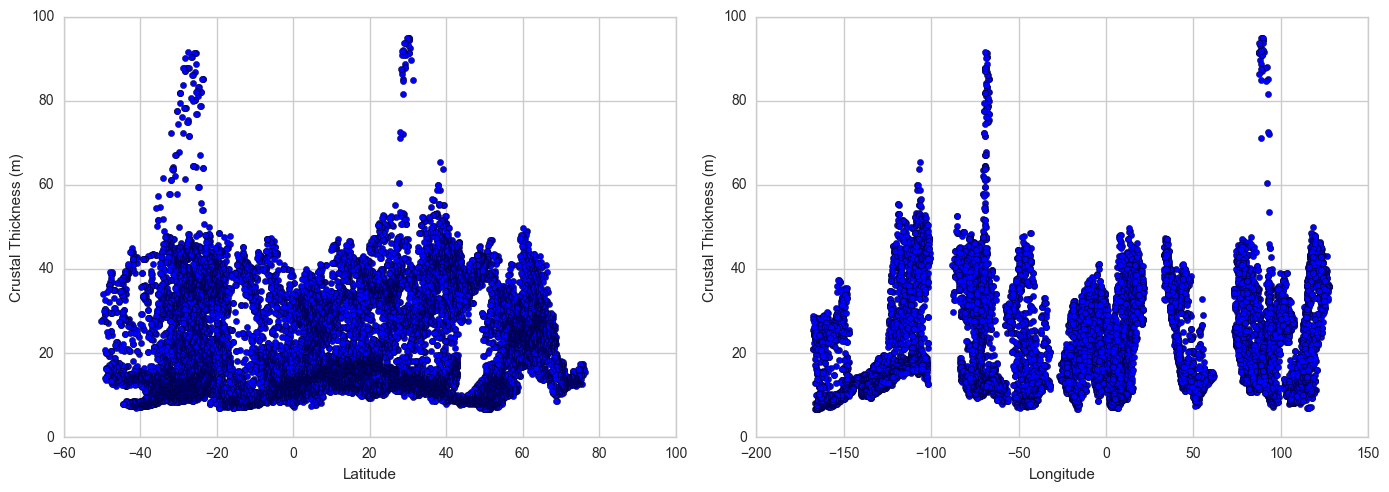

In [25]:
fig1 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax1 = fig1.add_subplot(1,2,1)
    ax1.scatter(df.Lat, df.CrustThk, label='')
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('Crustal Thickness (m)')

    ax2 = fig1.add_subplot(1,2,2)
    ax2.scatter(df.Lon, df.CrustThk)
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Crustal Thickness (m)')
    
    plt.tight_layout()
    plt.show()

Using all of the crust thickness data (both continental emergent and continental and oceanic submerged) this is no clear divisions in the data--save for the artificial partitions that can be seen in the longitude which reflect the 9 sampling areas chosen as part of this initial exploration. There is some evidence, however, in the latitude plot on the left of oceanic crust clustering in the sinuous band of coalesced data points along the base of the 'cloud' between approx. 12 and 20 km thickness. This could reflect the mass of oceanic crust in the data. 

Perhaps it would be instructive to remove the emergent portion (those thicknesses where the elevation is > 0 m) to see if that helps both to clarify the plot, and tune the Natural Breaks clusters...

In [30]:
# extract all records from the df where elevation > 0:
df_wet = df.query('Elevation < 0.0')

# now, rerun the N-B optimization, this time using only the submerged records:
pc_array = np.array(df_wet.ix[:,1])    # extract the crustal thickness column from the df
breaksList=[]

klasses=2
gvf = 0.0
gvf_acceptance=0.80
    
# compute F-J natural breaks and goodness of fit:
while(gvf < gvf_acceptance):
    print('Trying', klasses, 'class breaks...')
    # classify data using PySAL Natural Breaks Lib.
    breaks=ComputeNaturalBreaks(pc_array, klasses)

    # compute goodness of variance fit
    gvf = goodness_of_variance_fit(pc_array, breaks.bins)   #(data, nclasses)
    klasses+=1
    
breaksList.append(breaks.bins)  

print('Natural Breaks Optimization Result:')
print(breaksList)

Trying 2 class breaks...
Trying 3 class breaks...
Trying 4 class breaks...
Natural Breaks Optimization Result:
[array([ 11.403069,  15.555084,  22.370525,  44.235935])]


Interesting. Let's plot them submerged data and see if a more distinct pattern emerges:

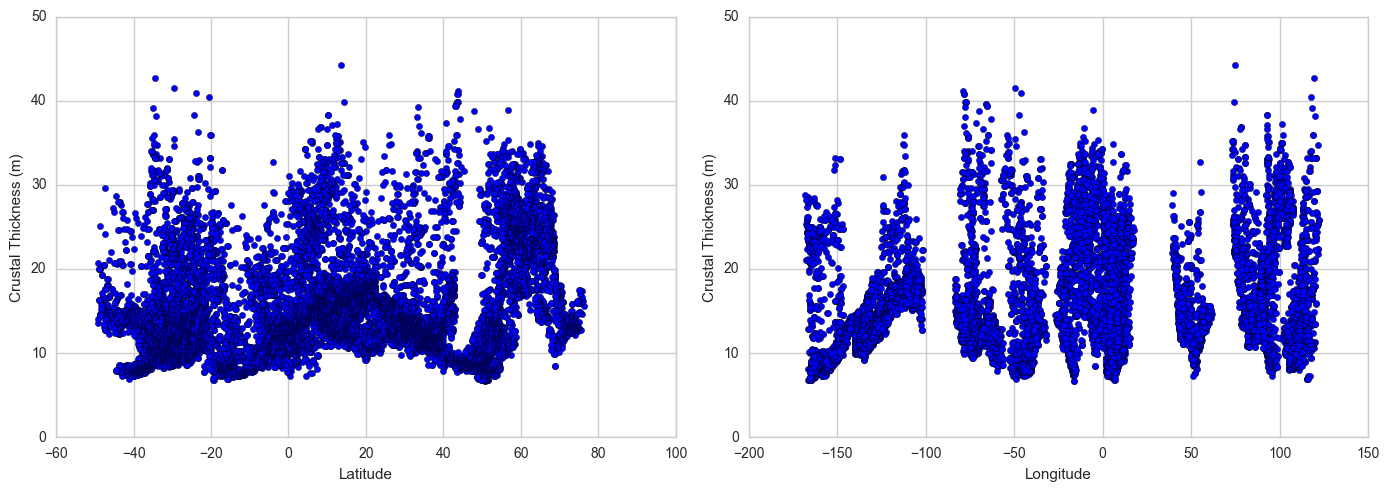

In [31]:
fig1 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax1 = fig1.add_subplot(1,2,1)
    ax1.scatter(df_wet.Lat, df_wet.CrustThk, label='')
    ax1.set_xlabel('Latitude')
    ax1.set_ylabel('Crustal Thickness (km)')

    ax2 = fig1.add_subplot(1,2,2)
    ax2.scatter(df_wet.Lon, df_wet.CrustThk)
    ax2.set_xlabel('Longitude')
    ax2.set_ylabel('Crustal Thickness (km)')
    
    plt.tight_layout()
    plt.show()

There remains a distinct coalesence of the data below 20 km thickness that probably reflects, in some crude way, the OCT. Perhaps the 15 m break revealed in the N-B for the subsurface only, could approximately fit what is seen [admittedly with some interpretive effort] in the latitude-thickness plot seen on the left...

__Next Q: How does crustal thickness vary, if at all, with changes in the local/regional magnetic field? What about gravity?__

First, we'll look at both the submergent and emergent data:

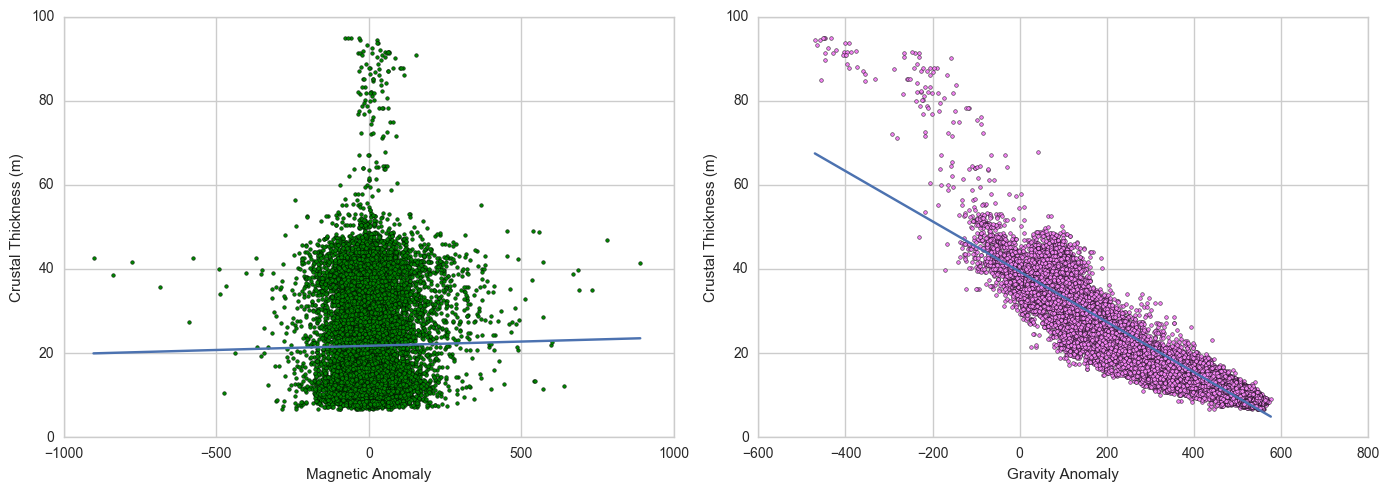

In [52]:
fig2 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax2 = fig2.add_subplot(1,2,1)
    ax2.scatter(df.Magnetic, df.CrustThk, s=7, c='green', label='')
    ax2.set_xlabel('Magnetic Anomaly')
    ax2.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax2.plot(np.unique(df.Magnetic), np.poly1d(np.polyfit(df.Magnetic, df.CrustThk, 1))(np.unique(df.Magnetic)))
    
    ax2 = fig2.add_subplot(1,2,2)
    ax2.scatter(df.Gravity, df.CrustThk, s=7, c='violet', label='')
    ax2.set_xlabel('Gravity Anomaly')
    ax2.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax2.plot(np.unique(df.Gravity), np.poly1d(np.polyfit(df.Gravity, df.CrustThk, 1))(np.unique(df.Gravity)))
    
    plt.tight_layout()
    plt.show()

Now, we look only at relationships below sea level:

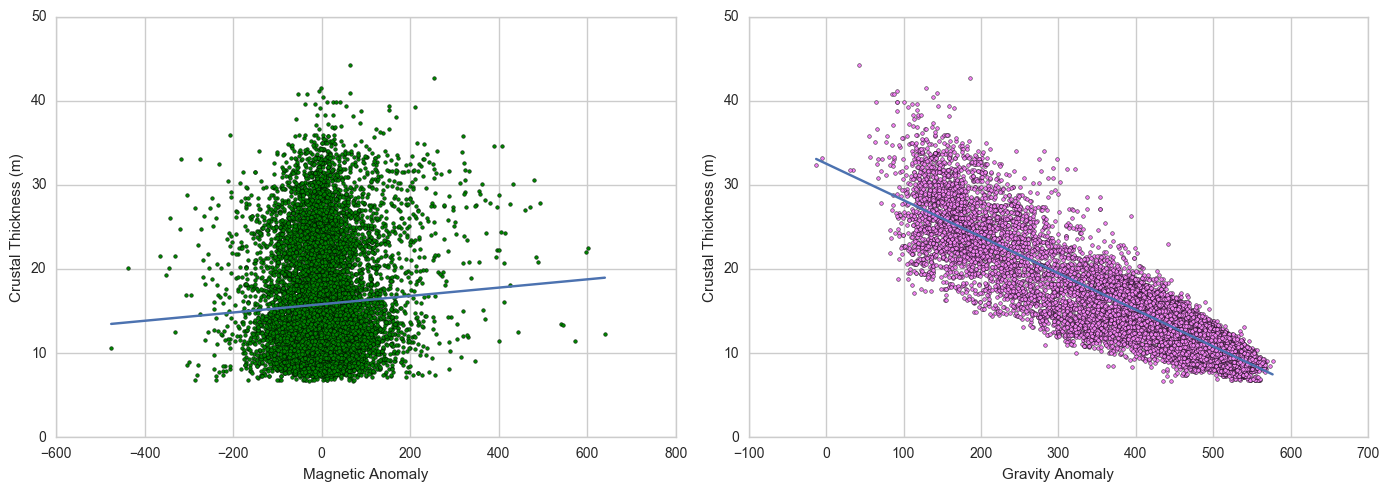

In [53]:
fig3 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax3 = fig3.add_subplot(1,2,1)
    ax3.scatter(df_wet.Magnetic, df_wet.CrustThk, s=7, c='green', label='')
    ax3.set_xlabel('Magnetic Anomaly')
    ax3.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax3.plot(np.unique(df_wet.Magnetic), np.poly1d(np.polyfit(df_wet.Magnetic, df_wet.CrustThk, 1))(np.unique(df_wet.Magnetic)))
    
    ax3 = fig3.add_subplot(1,2,2)
    ax3.scatter(df_wet.Gravity, df_wet.CrustThk, s=7, c='violet', label='')
    ax3.set_xlabel('Gravity Anomaly')
    ax3.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax3.plot(np.unique(df_wet.Gravity), np.poly1d(np.polyfit(df_wet.Gravity, df_wet.CrustThk, 1))(np.unique(df_wet.Gravity)))
    
    plt.tight_layout()
    plt.show()

Interesting...



__ Next Q: How does crustal thickness vary, if at all, with elevation?__

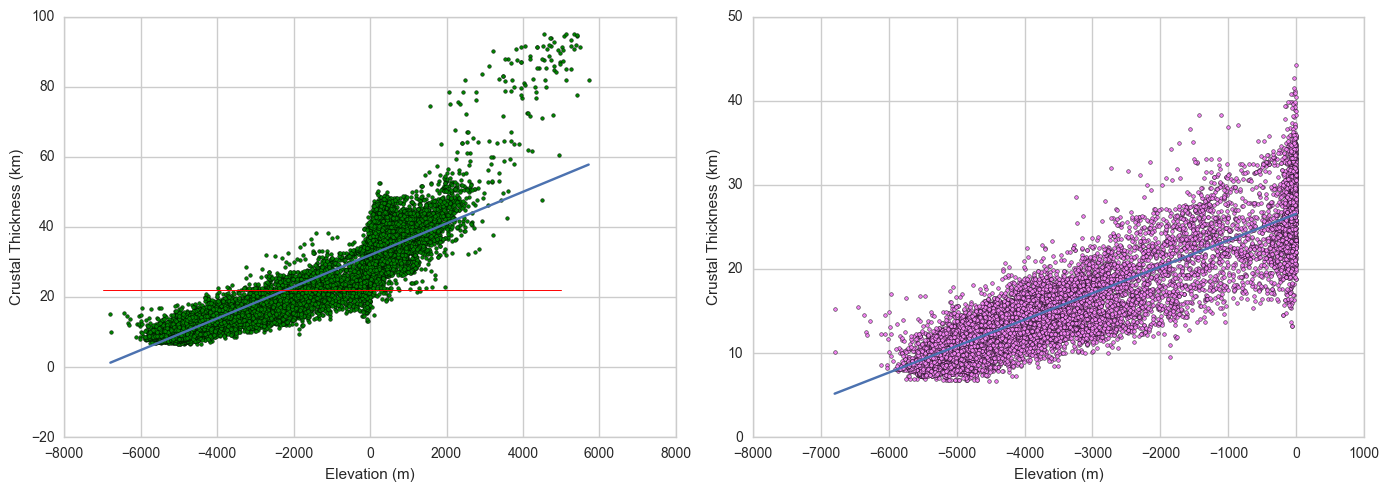

In [60]:
fig4 = plt.figure(figsize=(14,5))
with plt.style.context('seaborn-whitegrid'):
    ax4 = fig4.add_subplot(1,2,1)
    ax4.scatter(df.Elevation, df.CrustThk, s=7, c='green', label='')
    ax4.set_xlabel('Elevation (m)')
    ax4.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax4.plot(np.unique(df.Elevation), np.poly1d(np.polyfit(df.Elevation, df.CrustThk, 1))(np.unique(df.Elevation)))
    
    # added post-plot
    ax4.plot( (-7000,5000),(22,22), lw=0.7, c='r', label='22 km thickness partition' )
    
    
    ax4 = fig4.add_subplot(1,2,2)
    ax4.scatter(df_wet.Elevation, df_wet.CrustThk, s=7, c='violet', label='')
    ax4.set_xlabel('Elevation (m)')
    ax4.set_ylabel('Crustal Thickness (km)')
    # adding a best fit (regression) line:
    ax4.plot(np.unique(df_wet.Elevation), np.poly1d(np.polyfit(df_wet.Elevation, df_wet.CrustThk, 1))(np.unique(df_wet.Elevation)))
    
    plt.tight_layout()
    plt.show()

Depth (or height) and crustal thickness (overall) appear to share a curvilinear relationship--one that can be linearized by examining the submergent and emergent sections individually. Doing so, shows reasonably good linear relations. Further, one could also see a second linear-ish trend in those thicknesses greater than 35 to 40 km.  

Further, if we overprint some earlier results that attempted to partition, or cluster, crustal thickness from NOAA using Natural Breaks:

Natural Breaks Optimization Result:
[array([ 11.403069,  15.555084,  22.370525,  44.235935])]

...adding the 22.37 km partition (red line) to the overall elevation vs thickness plot (on the left)...

Continued on notebook: *CMM Sample Data (20k pnts) Crustal Thickness Analysis II*